In [141]:
#Basic imports
import sys

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import collections

DATA_DIR = "/dfs/scratch0/googlengrams/2012-eng-fic/"
sys.path.append("../langchange")

import ioutils as util
from cooccurrence import matstore
from statutils import plothelper, changepoint, trendestimator, seriesanalysis, mixedmodels

%matplotlib inline

In [352]:
year_words = util.load_pickle(DATA_DIR + "/info/freqnonstop_peryear-1900-2000-7.pkl")

In [353]:
# Loading basic word and frequency info
years = np.arange(1900, 2001)
freqs = util.load_pickle(DATA_DIR + "/info/freqnonstop_peryear-1900-2000-7-freqs.pkl")
# top year words contains only top 20000 words per year

In [354]:
#loading freq info
top_year_words = {}
for year, words in year_words.iteritems():
    top_year_words[year] = words[:10000]
all_words = set([word for year_words_list in top_year_words.values() for word in year_words])
year_freqs = collections.defaultdict(lambda : collections.defaultdict(lambda : float('nan')))
for year, words in top_year_words.iteritems():
    for word in words:
        year_freqs[word][year] = freqs[word][year]

In [335]:
# Load word lists
brown = util.load_word_list(MISC_DIR + "/brownwords.txt")
concrete = util.load_word_list(MISC_DIR + "/concretewords.txt")
abstract = util.load_word_list(MISC_DIR "/abstractwords.txt")
concrete_cmn = util.load_word_list(MISC_DIR + "/concretewords-cmn.txt")
abs_cmn = util.load_word_list(MISC_DIR + "/abstractwords-cmn.txt")
nouns = util.load_word_list(MISC_DIR + "/nouns.txt")
adjs = util.load_word_list(MISC_DIR + "/adjs.txt")
verbs = util.load_word_list(MISC_DIR + "/misc/verbs.txt")
advs = util.load_word_list(MISC_DIR + "/advs.txt")

In [355]:
# loading stats
# sums = magnitude, clusts = - polysemy, vols = rate of change, cents = centrality, knn_sums = sim. with nearest neighbours
sums = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
clusts = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/freqnonstop_peryear-1900-2000-7-top20000-weighted.pkl")
vols =  util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/volstats/freqnonstop_peryear-1900-2000-7-0.0-top20000-vols.pkl")
cents = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/secondnetstats-0-None/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
knn_sums = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/secondnetstats-0-5/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
disps =  util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/volstats/freqnonstop_peryear-1900-2000-7-0.0-top20000-disps.pkl")

In [356]:
# log transform as necessary
log_freqs = collections.defaultdict(lambda : collections.defaultdict(lambda : float('nan')))
for word, vals in year_freqs.iteritems():
    for year, freq in vals.iteritems():
        log_freqs[word][year] = np.log(freq)
log_sums = {word:{year:np.log(sum) for year, sum in vals.iteritems()} for word, vals in sums.iteritems()}
log_clusts = {word:{year:np.log(clust) for year, clust in vals.iteritems()} for word, vals in clusts.iteritems()}
log_cents = {word:{year:np.log(cent) for year, cent in vals.iteritems()} for word, vals in cents.iteritems()}
log_knn_sums = {word:{year:np.log(sum) for year, sum in vals.iteritems()} for word, vals in knn_sums.iteritems()}

In [359]:
# get means
log_freqs_med = seriesanalysis.get_series_mean_std_peryear(log_freqs, top_year_words)[0]
log_sums_med = seriesanalysis.get_series_mean_std_peryear(log_sums, top_year_words)[0]
log_clusts_med = seriesanalysis.get_series_mean_std_peryear(log_clusts, top_year_words)[0]
log_cents_med = seriesanalysis.get_series_mean_std_peryear(log_cents, top_year_words)[0]
log_knn_sums_med = seriesanalysis.get_series_mean_std_peryear(log_knn_sums, top_year_words)[0]

In [360]:
# Get successful new words
succ =  trendestimator.get_successful_new_words(year_freqs, s_buff=10, e_buff=10, not_present_min=0.1)

In [372]:
# Get unsuccessful new words
unsucc =  trendestimator.get_unsuccessful_new_words(year_freqs, s_buff=10, e_buff=10, not_present_max=0.95, not_present_min=0.2)

In [1137]:
# Function used to get nearest neighbours of a new word for their first ten years after birth. 
def get_seq_closest(embeds, word, start_year, num_years=10, n=15):
    closest = collections.defaultdict(float)
    for year in range(start_year, start_year + num_years):
        year_closest = embeds.get_embed(year).closest(word, n=100*n)
        for score, neigh in year_closest:
            closest[neigh] += score
    return sorted(closest, key = lambda neigh : closest[neigh], reverse=True)[0:n+1]

In [ ]:
# e.g., get words closest to fuck after it entered the core lexicon
get_seq_closest(first_orders, "fuck", 1965, n=10)

In [ ]:
# get the year-2000 frequency rank of fuck
year_words[2000].index("fuck")

In [371]:
# Remove words from new word sets that were manually labeled as proper nounds
bad_succ = set(util.load_word_list("/dfs/scratch0/googlengrams/misc/succ-new-words.txt"))
bad_unsucc = set(util.load_word_list("/dfs/scratch0/googlengrams/misc/unsucc-new-words.txt"))
succ = {word:year for word, year in succ.iteritems() if not word in bad_succ}
unsucc = {word:year for word, year in unsucc.iteritems() if not word in bad_unsucc}

In [378]:
# function to statistics about new word in years after its birth
def make_newwords_stat_series(word_births, val_func, years=30):
    series = collections.defaultdict(dict)
    for word, birth_year in word_births.iteritems():
        if birth_year > 1970:
            continue
        for i, year in enumerate(range(birth_year, birth_year + years)):
            val = val_func(word, year)
            if val == -1*np.inf:
                series[word][i] = np.nan
                continue
            series[word][i] = val
    return series
knn_func = lambda word, year : log_knn_sums[word][year] - log_knn_sums_med[year - 1900]
knn_s_series =  make_newwords_stat_series(succ, knn_func)
knn_u_series =  make_newwords_stat_series(unsucc, knn_func)
sum_func = lambda word, year : np.log(sums[word][year]) - log_sums_med[year - 1900]
sum_s_series =  make_newwords_stat_series(succ, sum_func)
sum_u_series =  make_newwords_stat_series(unsucc, sum_func)
freq_func = lambda word, year : np.log(year_freqs[word][year]) - log_freqs_med[year - 1900]
freq_s_series =  make_newwords_stat_series(succ, freq_func)
freq_u_series =  make_newwords_stat_series(unsucc, freq_func)
clust_func = lambda word, year : np.log(clusts[word][year]) - log_clusts_med[year - 1900]
clust_s_series =  make_newwords_stat_series(succ, clust_func)
clust_u_series =  make_newwords_stat_series(unsucc, clust_func)

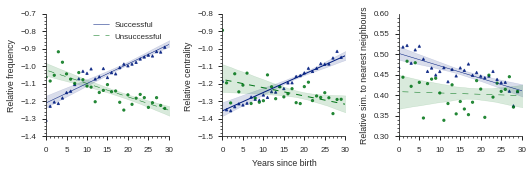

In [409]:
# Make figure 3a,b,c from the paper
s_series = succ
u_series = unsucc
sns.set_style("white")
sfreq = seriesanalysis.get_series_mean_std(freq_s_series, freq_s_series.keys(), start_year=0, end_year=29)[0]
ufreq = seriesanalysis.get_series_mean_std(freq_u_series, freq_u_series.keys(), start_year=0, end_year=29)[0]
sns.set_context("paper")
sns.set_style("white")
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["patch.linewidth"] = 0.5
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["axes.linewidth"] = 1.0
plt.rcParams["ytick.major.size"] = 4
plt.rcParams["ytick.major.width"] = 1
plt.rcParams["xtick.major.size"] = 4
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 0.75
plt.rcParams["xtick.minor.width"] = 0.75
#plt.rcParams["legend.fontsize"] = 7
plt.rcParams["figure.figsize"] = (7.5, 2.5)
fig, axs = plt.subplots(1,3)
sns.set_palette("dark")
ax = sns.regplot(np.arange(0,30), sfreq, marker='^', line_kws={'ls' : '-', 'lw' : 0.5},
                 scatter_kws={'s':5, 'linewidths' : (1,1)}, ax=axs[0])
sns.regplot(np.arange(0,30), ufreq, ax=ax, marker='o', line_kws={'ls' : '--', 'lw' : 0.5},
             scatter_kws={'s':5, 'linewidths' : (1,1)})
axs[0].set_xlim(0, 30)
#axs[0].set_ylim(-1.0, -0.4)
axs[0].legend(["Successful", "Unsuccessful"], loc='upper right')
axs[0].set_ylabel("Relative frequency")
ssum = seriesanalysis.get_series_mean_std(sum_s_series, s_series.keys(), start_year=0, end_year=29)[0]
usum = seriesanalysis.get_series_mean_std(sum_u_series, u_series.keys(), start_year=0, end_year=29)[0]
ax = sns.regplot(np.arange(0,30), ssum, marker='^', line_kws={'ls' : '-', 'lw' : 1},
                 scatter_kws={'s':5, 'linewidths' : (1,1)}, ax=axs[1], color=sns.color_palette()[0])
sns.regplot(np.arange(0,30), usum, ax=ax, marker='o', line_kws={'ls' : '--', 'lw' : 1},
             scatter_kws={'s':5, 'linewidths' : (1,1)}, color=sns.color_palette()[1])
axs[1].set_xlim(0, 30)
#axs[1].set_ylim(-1.4, -0.9)
axs[1].set_ylabel("Relative centrality")
sknn = seriesanalysis.get_series_mean_std(knn_s_series, s_series.keys(), start_year=0, end_year=29)[0]
uknn = seriesanalysis.get_series_mean_std(knn_u_series, u_series.keys(), start_year=0, end_year=29)[0]
ax = sns.regplot(np.arange(0,30), sknn, marker='^', line_kws={'ls' : '-', 'lw' : 0.5},
                 scatter_kws={'s':5, 'linewidths' : (1,1)}, ax=axs[2], color=sns.color_palette()[0])
sns.regplot(np.arange(0,30), uknn, ax=ax, marker='o', line_kws={'ls' : '--', 'lw' : 0.5},
             scatter_kws={'s':5, 'linewidths' : (1,1)}, color=sns.color_palette()[1])
axs[2].set_xlim(0, 30)
axs[2].set_ylim(0.3, 0.6)
axs[2].set_ylabel("Relative sim. to nearest neighbours")
axs[1].set_xlabel("Years since birth")
axs[0].minorticks_on()
axs[1].minorticks_on()
axs[2].minorticks_on()
sns.despine()
plt.tight_layout()
for axis in ['top','bottom','left','right']:
    for subplot in [0,1,2]:
        axs[subplot].spines[axis].set_linewidth(0.8)
plt.savefig("newwords.pdf")

In [399]:
# Function to get regression stats, 
#e.g. running this will give regresion of year vs. distance to nearest neighbours for unsuccessful words. 
trendestimator.trend_estimate_arr(uknn).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.1154
Date:                Sat, 10 Oct 2015   Prob (F-statistic):              0.737
Time:                        22:34:55   Log-Likelihood:                 51.906
No. Observations:                  30   AIC:                            -99.81
Df Residuals:                      28   BIC:                            -97.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4089      0.016     25.859      0.000         0.377     0.441
x1            -0.0003      0.001     -0.340      0.737        -0.002     0.002
==============================================================================
Omnibus:                        1.619   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.445   Jarque-Bera (JB):                1.296
Skew:                          -0.496   Prob(JB):                        0.523
Kurtosis:                       2.772   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""